In [34]:
import xarray as xr 

import sys
sys.path.append('/home/links/ct715/eddy_feedback')
import functions.eddy_feedback as ef 

In [35]:
ds = xr.open_mfdataset('/home/links/ct715/eddy_feedback/daily_datasets/jra55_djf_ep.nc',
                            parallel=True, chunks={'time': 31})
ds

<xarray.Dataset>
Dimensions:  (time: 5325, lon: 144, lat: 73, level: 37)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01T09:00:00 ... 2016-12-31T09:00:00
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    v        (time, level, lat, lon) float32 dask.array<chunksize=(31, 37, 73, 144), meta=np.ndarray>
    t        (time, level, lat, lon) float32 dask.array<chunksize=(31, 37, 73, 144), meta=np.ndarray>
    omega    (time, level, lat, lon) float32 dask.array<chunksize=(31, 37, 73, 144), meta=np.ndarray>
    u        (time, level, lat, lon) float32 dask.array<chunksize=(31, 37, 73, 144), meta=np.ndarray>
    ep1      (time, level, lat) float64 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>
    ep2      (time, level, lat) float64 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>
    div1     (time, level, lat) float64 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>
    div2     (time, level, lat) float64 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>
    ubar     (level, lat) float32 dask.array<chunksize=(37, 73), meta=np.ndarray>

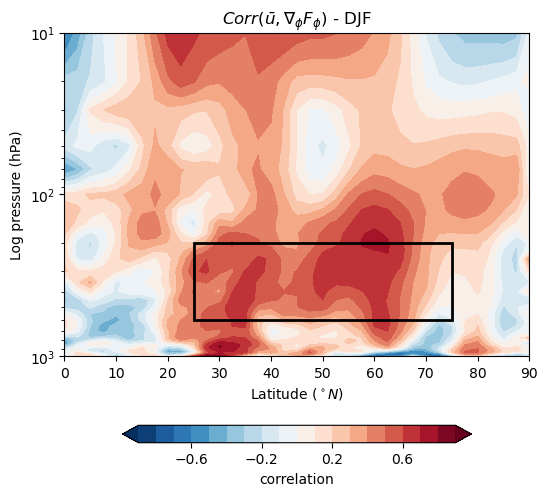

In [36]:
ef.correlation_contourf(ds)

In [37]:
def calculate_ef_parameter(ds, primitive=True, hemisphere='NH', top_atmos=10., reanalysis=True,
                           whole_area=True, which_level=None):

    """ 
    Input: Xarray dataset

    Output: Xarray dataArray of Eddy Feedback Parameter (EFP)
    """

    ## CONDITIONS
    
    # ensure variables are named correctly
    if 'lat' and 'lon' and 'level' and 'u' and 'v' and 't' not in ds:
        ds = ef.find_rename_variables(ds)  
    
    # Check to see if EP fluxes are in DataSet
    if not 'ep1' in ds:
        ds = ef.calculate_epfluxes_ubar(ds, primitive=primitive) 


    # Reduce dataset to 200-600hPa
    ds = ds.where( ds.level >= 200., drop=True ) 
    ds = ds.where( ds.level <= 600., drop=True ) 

    # choose hemisphere
    if hemisphere == 'SH':
        # set southern hermisphere
        ds = ds.where( ds.lat <= 0, drop=True )
    else:
        # set northern hemisphere
        ds = ds.where( ds.lat >= 0, drop=True )


    #-------------------------------------------------------------------

    ## SET UP TIME
    
    # remove unwanted variables
    vars = ['u', 'div1', 'div2']
    ds = ds[vars]
    
    # set variables and save them
    ubar = ds.u.mean(('lon'))
    div1 = ds.div1
    div2 = ds.div2
    
    if reanalysis == True:
        # separate time into annual means
        # and use .load() to force the calculation now
        ubar = ubar.groupby('time.year').mean('time').load()
        div1 = div1.groupby('time.year').mean('time').load()
        div2 = div2.groupby('time.year').mean('time').load()
    else:
        # separate time into annual means
        ubar = ubar.load()
        div1 = div1.load()
        div2 = div2.load()

    # calculate Pearson's correlation
    R = xr.corr(ubar, div1, dim='year')

    # calculate correlation squared (R^2)
    R = R**2


    # choose between whole area or individual levels
    if whole_area == True:
        # average over 200-600hPa
        R = R.mean(('level'))
    else:
        # take a slice at particular level
        R = R.sel( ds.level == which_level)


    return R

In [38]:
R = calculate_ef_parameter(ds)
R

<xarray.DataArray (lat: 37)>
array([0.02639128, 0.03256337, 0.03043114, 0.00365367, 0.02202321,
       0.01544554, 0.01391029, 0.03141198, 0.07144756, 0.16626294,
       0.30625139, 0.41413948, 0.42787419, 0.36157519, 0.31130392,
       0.29587331, 0.31579666, 0.27570393, 0.20631451, 0.19915429,
       0.22730695, 0.27197903, 0.37327213, 0.34697002, 0.27152255,
       0.25593696, 0.20723394, 0.12648576, 0.04734931, 0.01880553,
       0.04534228, 0.06190531, 0.06202594, 0.03728536, 0.04534733,
       0.02425772, 0.03961429])
Coordinates:
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... 10.0 7.5 5.0 2.5 0.0

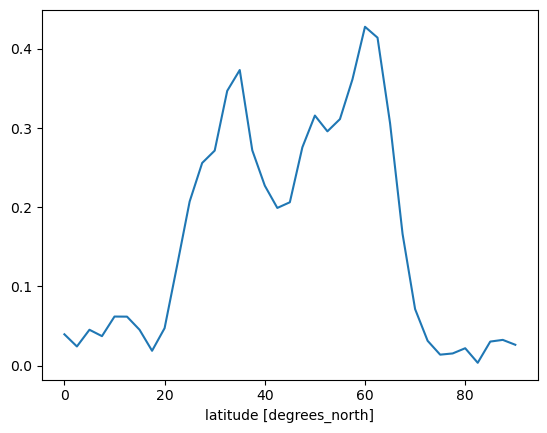

In [39]:
R.plot.line()

In [60]:
R = calculate_ef_parameter(ds)
R

<xarray.DataArray (lat: 37)>
array([ 0.03135512, -0.17485414, -0.16120205,  0.03411362,  0.13994412,
        0.11110593,  0.06191769,  0.09200665,  0.24315551,  0.40415318,
        0.54925883,  0.64216744,  0.65326969,  0.59419515,  0.54204954,
        0.52612644,  0.55266034,  0.51999152,  0.44946056,  0.44167296,
        0.45821174,  0.50689763,  0.60812977,  0.58695861,  0.51686939,
        0.49875036,  0.44497761,  0.34957654,  0.20980701,  0.05041608,
       -0.01333227, -0.04482461, -0.10799876, -0.10053068, -0.0853482 ,
       -0.07792402, -0.01056591])
Coordinates:
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... 10.0 7.5 5.0 2.5 0.0